> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a [tutorial](https://github.com/SunnySuite/SunnyTutorials/tree/main/tutorials)
 for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package,
 which enables dynamical simulations of ordered and thermally disordered spins with dipole
 and higher order moments._

In [1]:
# Welcome to a Sunny Tutorial on the $\sqrt{3}\times\sqrt{3}$ Kagome Antiferromagnet

**Script**: Distorted Kagome Lattice Calculation <br>
**Inspired by**:$\sqrt{3}\times\sqrt{3}$ Kagome Antiferromagnet SpinW tutorial
(Bjorn Fak and Sandor Toth https://spinw.org/tutorials/08tutorial).
**Authors**: Harry Lane <br>
**Date**: September 11, 2023  (Sunny 0.5.4) <br>
**Goal**: This script is to calculate the linear spin wave theory spectrum for the
$\sqrt{3} \times \sqrt{3}$ Kagome antiferromagnet and compare with the results from SpinW.

---
#### Loading Packages

In [2]:
using Sunny, GLMakie

#### Defining Custom Functions For This Script

In [3]:
function anneal!(sys,  integrator;  kTschedule, ndwell)
    nspins = prod(size(sys.dipoles));
    ensys  = zeros(length(kTschedule))
    for (i, kT) in enumerate(kTschedule)
        integrator.kT = kT
        for _ in 1:ndwell
            step!(sys, integrator)
        end
        ensys[i] = energy(sys)
    end
    return ensys/nspins
end

anneal! (generic function with 1 method)

---
### System Definition
Set up a `Crystal` with $P\overline{3}$ space group and Cr$^{+}$ ions on each site.

In [4]:
a = b = 6.0 # (Å)
c = 40.0
latvecs = lattice_vectors(a, b, c, 90, 90, 120)
types = ["Cr"]
crystal = Crystal(latvecs, [[1/2,0,0]], 147;types)

Crystal
HM symbol 'P -3' (147)
Lattice params a=6, b=6, c=40, α=90°, β=90°, γ=120°
Cell volume 1247
Type 'Cr':
   1. [0.5, 0, 0]
   2. [0, 0.5, 0]
   3. [0.5, 0.5, 0]


The next step is to add interactions. The command `print_symmetry_table` shows all
symmetry-allowed interactions up to a cutoff distance.

In [5]:
print_symmetry_table(crystal,7.0)

Atom 1
Type 'Cr', position [0.5, 0, 0], multiplicity 3
Allowed g-tensor: |   A  F+I  E-H |
                  | F-I    B  D+G |
                  | E+H  D-G    C |
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]
Allowed exchange matrix: |   A  F+I  E-H |
                         | F-I    B  D+G |
                         | E+H  D-G    C |
Allowed DM vector: [G H I]

Bond(2, 3, [0, 0, 0])
Distance 3, coordination 4
Connects 'Cr' at [0, 0.5, 0] to 'Cr' at [0.5, 0.5, 0]
Allowed exchange matrix: |   A  F+I  E-H |
                         | F-I    B  D+G |
                         | E+H  D-G    C |
Allowed DM vector: [G H I]

Bond(2, 1, [0, 

We can now create a `System` with $S=1$ spins and specify `dipole` mode.

In [6]:
sys = System(crystal,(9,9,1),[SpinInfo(1,S=1,g=2)],:dipole)

System [Dipole mode]
Lattice: (9, 9, 1)×3


We now add nearest-neighbor antiferromagnetic interactions.

In [7]:
set_exchange!(sys,1.0,Bond(2,3,[0,0,0]))

---
### Search for the system ground-state

We now have two options. If we happen to know that the ground state we
can use `define_magnetic_structure` to prescribe a magnetic sturcture, or we can
take advantage of the tools that Sunny provides to find the magnetic ground state.
Let us try simulated annealing followed by gradient descent.

In [8]:
randomize_spins!(sys)
Δt = 0.01
λ = 0.1
langevin = Langevin(Δt; kT=0.0, λ)
kTs = [100 * 0.9^k for k in 0:200];
anneal!(sys,langevin;kTschedule=kTs,ndwell=10_000);
langevin.kT = 0.0
for _ ∈ 1:10_000
    step!(sys, langevin)
end
for i ∈ 1:20
    minimize_energy!(sys;maxiters=10_000)
end

Given the frustrated nature of the interactions, it is difficult to thermalize a single
$\mathbf{Q}$ magnetic structure.

Dominant wavevectors for spin sublattices:

    [1/3, 4/9, 0]           8.72% weight
    [-1/3, -4/9, 0]         8.72%
    [2/9, 1/3, 0]           4.26%
    [-2/9, -1/3, 0]         4.26%
    [4/9, 1/9, 0]           2.90%
    [-4/9, -1/9, 0]         2.90%
    [1/3, 1/3, 0]           2.81%
    [-1/3, -1/3, 0]         2.81%
    [0, 0, 0]               2.47%
    [1/9, 4/9, 0]           2.10%
    [-1/9, -4/9, 0]         2.10%
    ...                     ...


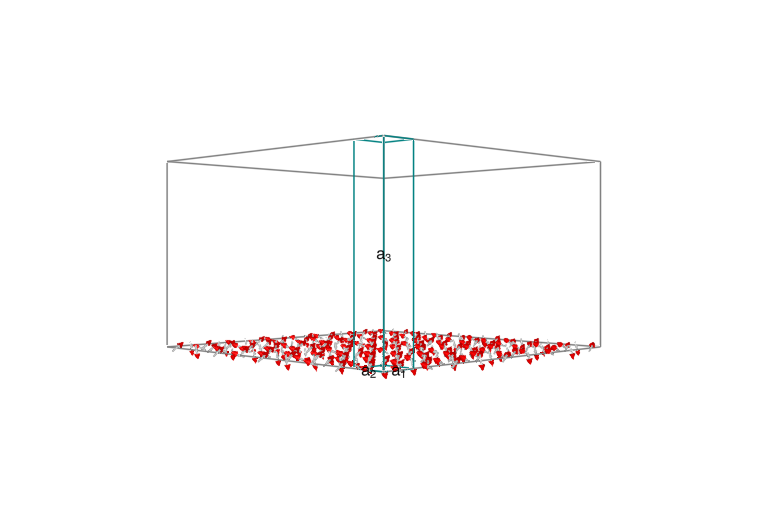

In [9]:
print_wrapped_intensities(sys)
plot_spins(sys)

#Instead let's build the known magnetic structure.

Let's see if we can do better than the (3,3,1) lattice that we would naively choose.

In [10]:
kvec = -[1/3,1/3,0]
n    = [0,0,1]
Slist=[[0,1,0],[0,1,0],[-1,-1,0]]
for nsub in 1:3
    set_spiral_order_on_sublattice!(sys, nsub ;q=kvec,axis=n,S0=Slist[nsub])
end
plot_spins(sys)
print_wrapped_intensities(sys)

┌ Warning: Wavevector [-1/3, -1/3, 0] is incommensurate with system.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:254
┌ Warning: Wavevector [-1/3, -1/3, 0] is incommensurate with system.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:254
┌ Warning: Wavevector [-1/3, -1/3, 0] is incommensurate with system.
└ @ Sunny ~/.julia/packages/Sunny/Z8eOT/src/MagneticOrdering.jl:254
Dominant wavevectors for spin sublattices:

    [1/3, 1/3, 0]          50.00% weight
    [-1/3, -1/3, 0]        50.00%


Success! This is telling us that we can describe the structure using
latsize=(3,3,1).

---
### Calculating Spin Wave Theory

The next step is to build a `SpinWaveTheory` object.

In [11]:
swt = SpinWaveTheory(sys;energy_ϵ=4e-2);

Before calculating the linear spin wave intensity, we must define a path in reciprocal space.

In [12]:
points_rlu = [[-1/2 0 0],[0 0 0],[1 1 0]];
density = 100
path, xticks = reciprocal_space_path(crystal,points_rlu, density);

Defining the scattering formula

In [13]:
γ = 0.15 # width in meV
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))

Quantum Scattering Intensity Formula
At any (Q,ω), with S = S(Q,ωᵢ):

  Intensity(Q,ω) = ∑ᵢ Kernel(ω-ωᵢ) ∑_ij (I - Q⊗Q){i,j} S{i,j}
                                   
                                   (i,j = Sx,Sy,Sz)

Intensity(ω) reported


Calculating the spin-waves

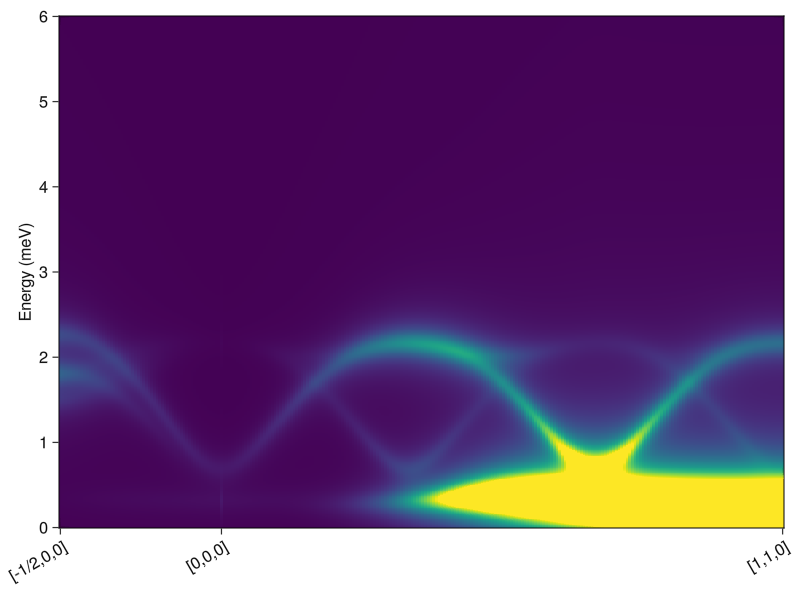

In [14]:
energies = collect(0:0.01:6)  # 0 < ω < 6 (meV).
is = intensities_broadened(swt, [q for q in path], energies, broadened_formula)
fig = Figure()
ax = Axis(fig[1,1]; ylabel="Energy (meV)", xticks, xticklabelrotation=π/6)
heatmap!(ax, 1:size(is, 1), energies, is,colorrange = (0,2.0))
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*